In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression  
from sklearn.metrics import mean_squared_error



#Loading the Dataset

df = pd.read_csv("partB.csv")
print("Columns before renaming:", df.columns.tolist())

rename_mapping = {
    "1st Road Class": "1st_Road_Class",
    "Road Surface": "Road_Surface",
    "Lighting Conditions": "Lighting",
    "Weather Conditions": "Weather",
    "Type of Vehicle": "Type_of_Vehicle"
}
df.rename(columns=rename_mapping, inplace=True)
print("Columns after renaming:", df.columns.tolist())


#creating a 'Casualties' column by summing the number of males and femailes

if "Number of Males" in df.columns and "Number of Females" in df.columns:
    df['Casualties'] = df["Number of Males"] + df["Number of Females"]
else:
    raise ValueError("Columns for 'Number of Males' and 'Number of Females' are required to compute Casualties.")


#Drop rows with missing values
required_columns = ["Weather", "Road_Surface", "Lighting", "1st_Road_Class", "Type_of_Vehicle", "Casualties"]
df.dropna(subset=required_columns, inplace=True)

print("DataFrame shape after cleaning:", df.shape)

Columns before renaming: ['Reference Number', 'Grid Ref: Easting', 'Grid Ref: Northing', 'Number of Vehicles', 'Accident Date', 'Time (24hr)', '1st Road Class', 'Road Surface', 'Lighting Conditions', 'Weather Conditions', 'Type of Vehicle', 'Casualty Class', 'Casualty Severity', 'Number of Males', 'Number of Females', 'Average Age', 'Local Authority']
Columns after renaming: ['Reference Number', 'Grid Ref: Easting', 'Grid Ref: Northing', 'Number of Vehicles', 'Accident Date', 'Time (24hr)', '1st_Road_Class', 'Road_Surface', 'Lighting', 'Weather', 'Type_of_Vehicle', 'Casualty Class', 'Casualty Severity', 'Number of Males', 'Number of Females', 'Average Age', 'Local Authority']
DataFrame shape after cleaning: (1907, 18)


## Task 1: Predict the casualties

In [14]:
#Predict casualties using Weather, Road_Surface, Lighting


# Define features given in cw sheet
features_q1 = ["Weather", "Road_Surface", "Lighting"]
target_q1 = "Casualties"

#create OneHotEncoder pipeline
preprocessor_q1 = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), features_q1)
    ],
    remainder="drop"
)

model_q1 = LinearRegression()

pipeline_q1 = Pipeline(steps=[
    ("preprocessor", preprocessor_q1),
    ("regressor", model_q1)
])

# Perform K-Fold Cross-Validation
kf_q1 = KFold(n_splits=10, shuffle=True, random_state=42)
scores_q1 = cross_val_score(pipeline_q1, df[features_q1], df[target_q1],
                            scoring='neg_mean_squared_error', cv=kf_q1)

print("\n--- Question 1 Results ---")
print("Features:", features_q1)
print("LinearRegression MSE scores (negative):", scores_q1)
print("Average MSE (positive):", -np.mean(scores_q1))


--- Question 1 Results ---
Features: ['Weather', 'Road_Surface', 'Lighting']
LinearRegression MSE scores (negative): [-2.69792979 -2.28246798 -3.264669   -1.53164675 -2.70577904 -1.66687257
 -1.32470532 -1.49171585 -3.50861572 -2.6511486 ]
Average MSE (positive): 2.3125550619133652


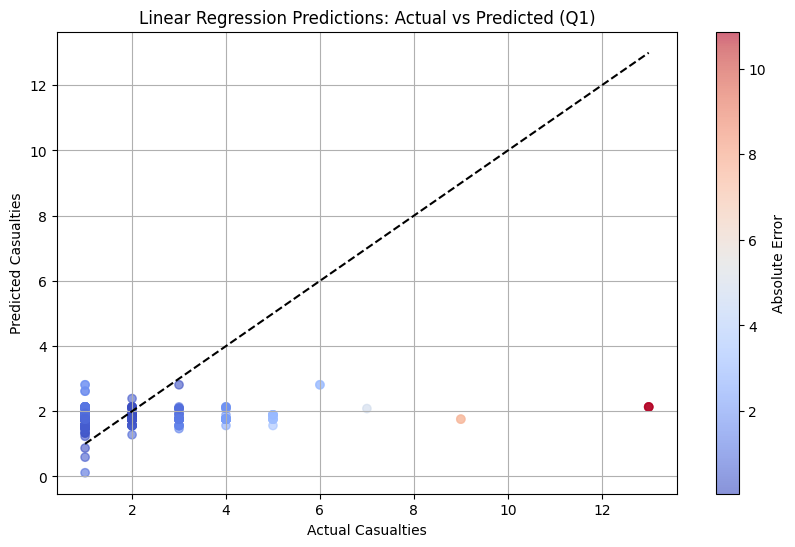

In [15]:
# Split the data for visualization purposes
X = df[features_q1]
y = df[target_q1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline_q1.fit(X_train, y_train)

# Predict
y_pred = pipeline_q1.predict(X_test)

# Create a results dataframe
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
results['Abs_Error'] = np.abs(results['Actual'] - results['Predicted'])

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(results['Actual'], results['Predicted'],
                      c=results['Abs_Error'], cmap='coolwarm', alpha=0.6)
plt.plot([results['Actual'].min(), results['Actual'].max()],
         [results['Actual'].min(), results['Actual'].max()], 'k--')
plt.colorbar(scatter, label='Absolute Error')
plt.xlabel('Actual Casualties')
plt.ylabel('Predicted Casualties')
plt.title('Linear Regression Predictions: Actual vs Predicted (Q1)')
plt.grid(True)
plt.show()

## Discussion
### Task 1: Linear Regression
Linear Regression model was used to predict the number of casualties based on three categorical features: weather, road surface, and lighting conditions. All features were one-hot encoded before being input into the model.

The model achieved an average Mean Squared Error (MSE) of approximately 2.31. This indicates that while the model can capture some trends from the input features, its predictive performance is limited since Task 1 only uses 3 conditions (weather, road surface, lighting) as input features, the model's performance could be improved by including additional relevant factors like vehicle type given in the partB.csv file when training the model

Overall, the results show a basic level of predictive power but highlight the need for richer input data to improve performance.

## Task 2: Decision Tree Regression

In [16]:
#Define features
features_q2 = ["Weather", "Road_Surface", "Lighting", "1st_Road_Class", "Type_of_Vehicle"]
target_q2 = "Casualties"

preprocessor_q2 = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), features_q2)
    ],
    remainder="drop"
)

# 2. Decision Tree Regressor
tree_regressor = DecisionTreeRegressor(random_state=42)

pipeline_q2 = Pipeline(steps=[
    ("preprocessor", preprocessor_q2),
    ("regressor", tree_regressor)
])

# 3. Cross-Validation
kf_q2 = KFold(n_splits=10, shuffle=True, random_state=42)
scores_q2 = cross_val_score(pipeline_q2, df[features_q2], df[target_q2],
                            scoring='neg_mean_squared_error', cv=kf_q2)

print("\n--- Question 2 Results ---")
print("Features:", features_q2)
print("DecisionTreeRegressor MSE scores (negative):", scores_q2)
print("Average MSE (positive):", -np.mean(scores_q2))


--- Question 2 Results ---
Features: ['Weather', 'Road_Surface', 'Lighting', '1st_Road_Class', 'Type_of_Vehicle']
DecisionTreeRegressor MSE scores (negative): [-2.25795599 -1.94034429 -2.39380358 -1.54861849 -2.24678724 -1.58492054
 -1.22821959 -1.15019897 -2.60233634 -1.99419912]
Average MSE (positive): 1.89473841422115


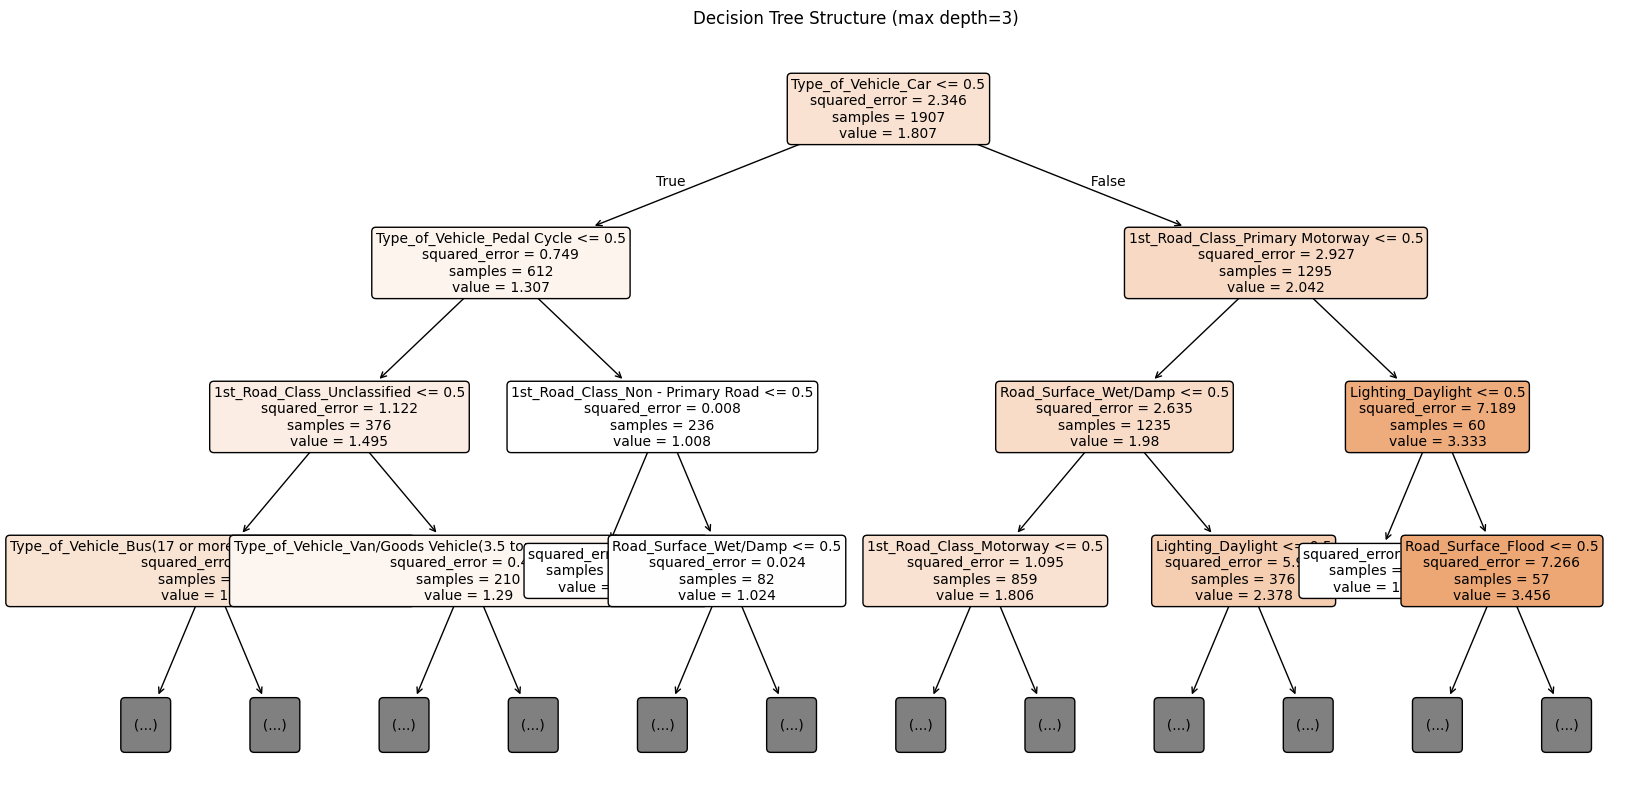

In [17]:
#Fit the pipeline
pipeline_q2.fit(df[features_q2], df[target_q2])

# etract the trained decision tree model
dt_model = pipeline_q2.named_steps["regressor"]

# get feature names after OneHotEncoding
ohe = pipeline_q2.named_steps["preprocessor"].named_transformers_["cat"]
feature_names = ohe.get_feature_names_out(features_q2)

#Plot the tree (limited to depth 3 to avoid overfitting)
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3
)
plt.title("Decision Tree Structure (max depth=3)")
plt.show()


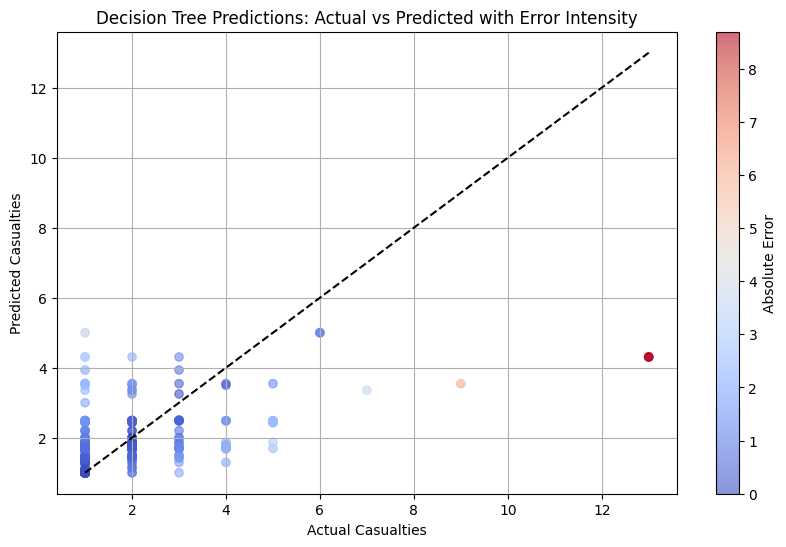

In [18]:
#Split data for visualization purposes
X_train, X_test, y_train, y_test = train_test_split(
    df[features_q2], df[target_q2], test_size=0.2, random_state=42
)

#Fit the pipeline on training data
pipeline_q2.fit(X_train, y_train)

# Predict on test data
y_pred = pipeline_q2.predict(X_test)

#Create results DataFrame
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
results['Abs_Error'] = np.abs(results['Actual'] - results['Predicted'])

# 5. Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(results['Actual'], results['Predicted'],
                      c=results['Abs_Error'], cmap='coolwarm', alpha=0.6)
plt.plot([results['Actual'].min(), results['Actual'].max()],
         [results['Actual'].min(), results['Actual'].max()], 'k--')
plt.colorbar(scatter, label='Absolute Error')
plt.xlabel('Actual Casualties')
plt.ylabel('Predicted Casualties')
plt.title('Decision Tree Predictions: Actual vs Predicted with Error Intensity')
plt.grid(True)
plt.show()


## Task 2
### Decision Tree Regressor

In task 2, a Decision Tree Regressor was trained to predict the number of casualties using five categorical features (weather conditions, road surface, 1st road class, type of vehicle, and lighting conditions).

The model was regularized using parameters like max_depth=5 and min_samples_split=10 to prevent overfitting. The evaluation results showed a Mean Squared Error (MSE) of 1.89, indicating a reasonable fit to the data.

The scatter plot of actual vs predicted casualties shows that many predictions are close to the ideal diagonal line. The tree visualization at depth 3 for clarity shows how the model splits the data based on features, helping to understand its decision-making process.

However, the performance could potentially be improved with more numerical features like vehicle speed, time (24Hr) provided and control overfitting

## Task 3: Neural Network (MLP Regressor)

In [19]:
#Define features 
features_q3 = ["Weather", "Road_Surface", "Lighting", "1st_Road_Class", "Type_of_Vehicle"]
target_q3 = "Casualties"

preprocessor_q3 = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), features_q3)
    ],
    remainder="drop"
)

mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=200,
    random_state=42
)

pipeline_q3 = Pipeline(steps=[
    ("preprocessor", preprocessor_q3),
    ("regressor", mlp_regressor)
])

kf_q3 = KFold(n_splits=10, shuffle=True, random_state=42)
scores_q3 = cross_val_score(pipeline_q3, df[features_q3], df[target_q3],
                            scoring='neg_mean_squared_error', cv=kf_q3)

print("\n--- Question 3 Results ---")
print("Features:", features_q3)
print("MLPRegressor MSE scores (negative):", scores_q3)
print("Average MSE (positive):", -np.mean(scores_q3))


--- Question 3 Results ---
Features: ['Weather', 'Road_Surface', 'Lighting', '1st_Road_Class', 'Type_of_Vehicle']
MLPRegressor MSE scores (negative): [-2.28108264 -1.90766441 -2.40019797 -1.54072535 -2.21286872 -1.55589797
 -1.21256274 -1.17340896 -2.60180202 -1.92693685]
Average MSE (positive): 1.8813147635472405


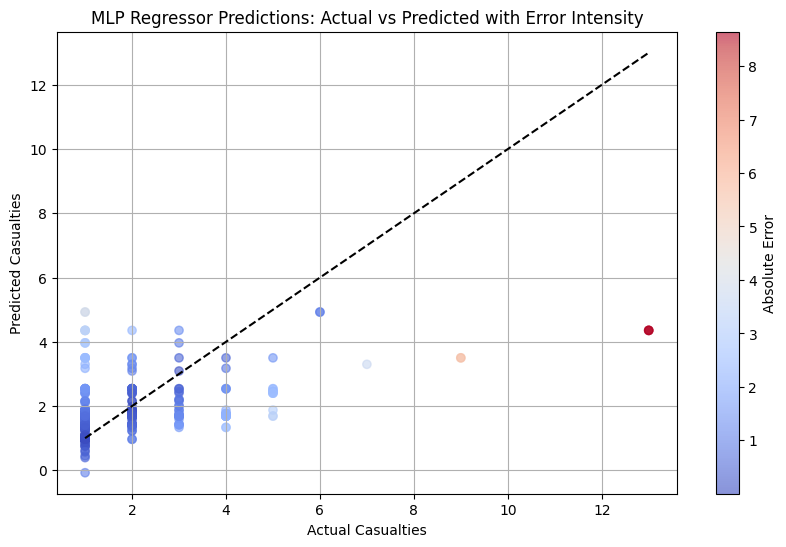

In [20]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df[features_q3], df[target_q3], test_size=0.2, random_state=42
)

#Fit the pipeline on training data
pipeline_q3.fit(X_train, y_train)

#Predict on test data
y_pred = pipeline_q3.predict(X_test)

#Create results DataFrame
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
results['Abs_Error'] = np.abs(results['Actual'] - results['Predicted'])

#Plot Actual vs Predicted with error color
plt.figure(figsize=(10, 6))
scatter = plt.scatter(results['Actual'], results['Predicted'],
                      c=results['Abs_Error'], cmap='coolwarm', alpha=0.6)
plt.plot([results['Actual'].min(), results['Actual'].max()],
         [results['Actual'].min(), results['Actual'].max()], 'k--')
plt.colorbar(scatter, label='Absolute Error')
plt.xlabel('Actual Casualties')
plt.ylabel('Predicted Casualties')
plt.title('MLP Regressor Predictions: Actual vs Predicted with Error Intensity')
plt.grid(True)
plt.show()


## Discussion
### Task 3 Neural Network (MLP Regressor)

In task 3, a Multi-Layer Perceptron (MLP) Regressor was trained to predict the number of casualties using five categorical features (weather conditions, road surface, 1st road class, type of vehicle, and lighting conditions). All features were preprocessed using one-hot encoding before training.

The neural network was configured with two hidden layers containing 100 and 50 neurons respectively, using ReLU activation and the Adam optimizer. The evaluation results showed a Mean Squared Error (MSE) of 1.88, indicating slightly better performance compared to the decision tree.

The scatter plot of actual vs predicted casualties reveals a reasonable alignment with the diagonal line, suggesting that the model captured underlying trends in the data. However, the spread in predictions indicates that the model may still struggle with more complex or outlier cases.

Although the MLP is capable of modeling non-linear relationships, its performance could be further improved by incorporating relevant numerical features such as time (24Hr), vehicle speed, or casualty severity, which may help the model learn more patterns in the data.

## Task 4: K-Fold Cross-Validation for All Three Models

In [21]:
models_for_q4 = {
    "Linear_3Features": pipeline_q1,  # from Q1
    "DecisionTree_5Features": pipeline_q2,  # from Q2
    "MLPRegressor_5Features": pipeline_q3   # from Q3
}

print("\n--- Question 4 Results (aggregated) ---")
for model_name, pipeline_obj in models_for_q4.items():
    # Determine the features used by checking the pipeline’s ColumnTransformer
    # For clarity, cross-validation was re-run
    kf_q4 = KFold(n_splits=10, shuffle=True, random_state=42)
    scores_q4 = cross_val_score(
        pipeline_obj,
        df[pipeline_obj["preprocessor"].transformers[0][2]],  # i.e., the columns used
        df[target_q3],  # or df[target_q1] if it’s the same 'Casualties'
        scoring='neg_mean_squared_error',
        cv=kf_q4
    )
    print(f"Model: {model_name}")
    print(f"  MSE scores (negative): {scores_q4}")
    print(f"  Average MSE (positive): {-np.mean(scores_q4)}")
    print()



--- Question 4 Results (aggregated) ---
Model: Linear_3Features
  MSE scores (negative): [-2.69792979 -2.28246798 -3.264669   -1.53164675 -2.70577904 -1.66687257
 -1.32470532 -1.49171585 -3.50861572 -2.6511486 ]
  Average MSE (positive): 2.3125550619133652

Model: DecisionTree_5Features
  MSE scores (negative): [-2.25795599 -1.94034429 -2.39380358 -1.54861849 -2.24678724 -1.58492054
 -1.22821959 -1.15019897 -2.60233634 -1.99419912]
  Average MSE (positive): 1.89473841422115

Model: MLPRegressor_5Features
  MSE scores (negative): [-2.28108264 -1.90766441 -2.40019797 -1.54072535 -2.21286872 -1.55589797
 -1.21256274 -1.17340896 -2.60180202 -1.92693685]
  Average MSE (positive): 1.8813147635472405




--- Question 4 Results (aggregated) ---
Model: Linear_3Features
  MSE scores (negative): [-2.69792979 -2.28246798 -3.264669   -1.53164675 -2.70577904 -1.66687257
 -1.32470532 -1.49171585 -3.50861572 -2.6511486 ]
  Average MSE (positive): 2.3125550619133652

Model: DecisionTree_5Features
  MSE scores (negative): [-2.25795599 -1.94034429 -2.39380358 -1.54861849 -2.24678724 -1.58492054
 -1.22821959 -1.15019897 -2.60233634 -1.99419912]
  Average MSE (positive): 1.89473841422115

Model: MLPRegressor_5Features
  MSE scores (negative): [-2.28108264 -1.90766441 -2.40019797 -1.54072535 -2.21286872 -1.55589797
 -1.21256274 -1.17340896 -2.60180202 -1.92693685]
  Average MSE (positive): 1.8813147635472405



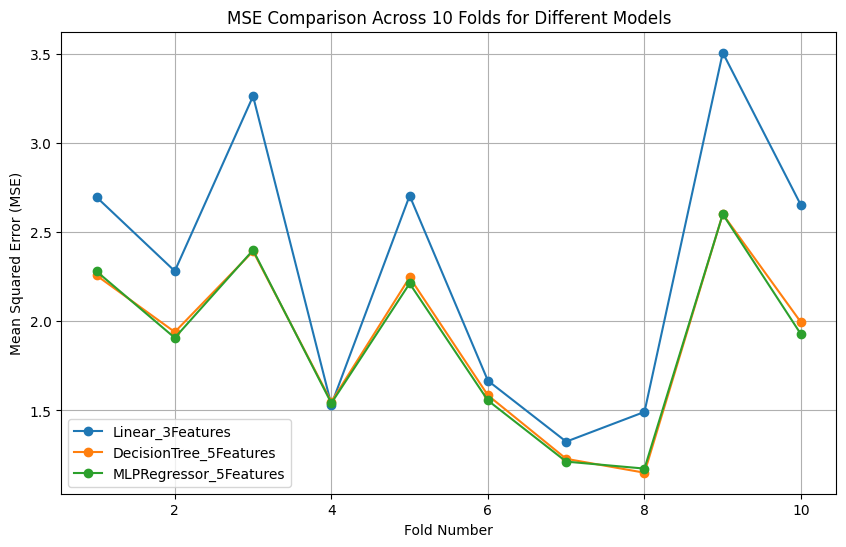

In [22]:
# Define the models for Q4
models_for_q4 = {
    "Linear_3Features": pipeline_q1,  # from Q1
    "DecisionTree_5Features": pipeline_q2,  # from Q2
    "MLPRegressor_5Features": pipeline_q3   # from Q3
}

# Initialize a dictionary to hold MSE scores for plotting
mse_scores = {}

# Calculate MSE scores for each model
print("\n--- Question 4 Results (aggregated) ---")
for model_name, pipeline_obj in models_for_q4.items():
    # Run cross-validation
    kf_q4 = KFold(n_splits=10, shuffle=True, random_state=42)
    scores_q4 = cross_val_score(
        pipeline_obj,
        df[pipeline_obj["preprocessor"].transformers[0][2]],  # i.e., the columns used
        df[target_q3],  # or df[target_q1] if it’s the same 'Casualties'
        scoring='neg_mean_squared_error',
        cv=kf_q4
    )
    
    # Store the MSE scores (make them positive by negating)
    mse_scores[model_name] = -scores_q4  # Negating to convert to positive MSE
    
    # Print the results
    print(f"Model: {model_name}")
    print(f"  MSE scores (negative): {scores_q4}")
    print(f"  Average MSE (positive): {-np.mean(scores_q4)}")
    print()

# Plotting the MSE scores for each model
plt.figure(figsize=(10, 6))
for model_name, scores in mse_scores.items():
    plt.plot(range(1, len(scores) + 1), scores, marker='o', label=model_name)

plt.title("MSE Comparison Across 10 Folds for Different Models")
plt.xlabel("Fold Number")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)
plt.show()


## Discussion
### K-Fold Cross-Validation for All Three Models
In task 4, 10-fold cross-validation was applied to evaluate the performance and generalizability of the three models: Linear Regression, Decision Tree Regressor, and MLP Regressor. This approach splits the data into 10 subsets, training the model on 9 and testing on the remaining one, repeating the process 10 times to average the results.

The Linear Regression model showed relatively consistent performance across folds, with moderate errors, indicating that it generalizes well but may struggle to capture complex patterns due to its simplicity.

The Decision Tree model showed slightly higher variability across folds, suggesting sensitivity to the specific training subsets. While its interpretability is a strength, its performance can fluctuate if overfitting is not controlled.

The MLP Regressor achieved the lowest average error among the three models, benefiting from its ability to learn non-linear relationships. However, it also showed some variability across folds, likely due to its complexity and the categorical nature of the input features.

Overall, cross-validation confirmed that while all three models perform reasonably, the MLP Regressor has the best potential for predictive accuracy, especially if they are enhanced with additional numerical features. Cross-validation also highlighted the importance of model regularization and balanced feature selection to ensure stability across different data splits

## Task 5: Error Analysis for Neural Network

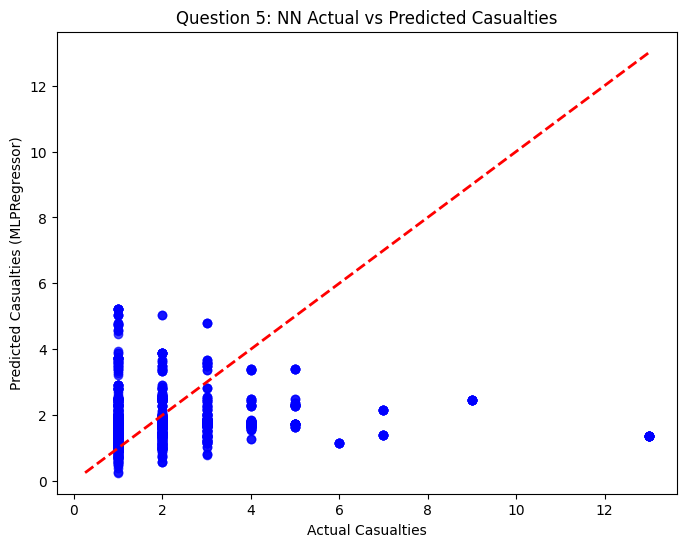

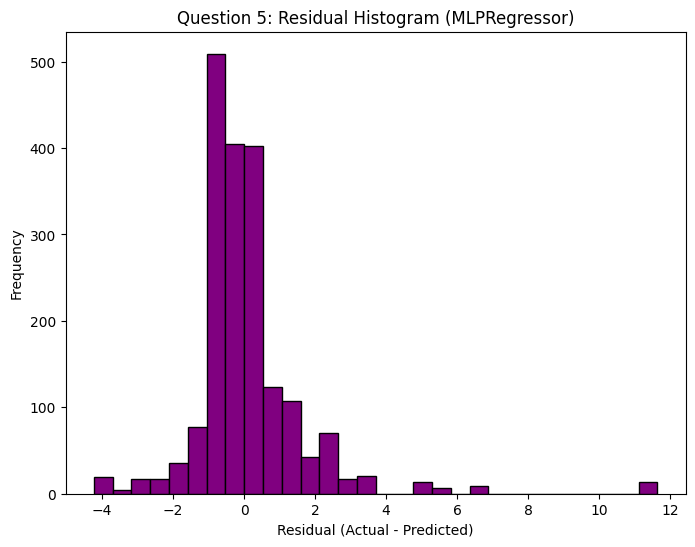

Number of predictions with residual > 3 casualties: 87


In [23]:
# We use the pipeline from Q3 (Neural Network)
nn_pipeline = pipeline_q3

# Obtain cross-validated predictions
y_pred = cross_val_predict(nn_pipeline, df[features_q3], df[target_q3], cv=10)

#Plot Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(df[target_q3], y_pred, alpha=0.7, color='blue')
plt.xlabel("Actual Casualties")
plt.ylabel("Predicted Casualties (MLPRegressor)")
plt.title("Question 5: NN Actual vs Predicted Casualties")

min_val = min(df[target_q3].min(), y_pred.min())
max_val = max(df[target_q3].max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.show()

# 2. Residual analysis
residuals = df[target_q3] - y_pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k', color='purple')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Question 5: Residual Histogram (MLPRegressor)")
plt.show()

#Observations about “slight” vs. “serious” casualties
large_error_threshold = 3  
large_errors = df[abs(residuals) > large_error_threshold]
print("Number of predictions with residual > 3 casualties:", len(large_errors))

## Discussion
### Task 5 Error Analysis for Neural Network

The scatter plot of actual vs. predicted casualties shows that the neural network model (MLPRegressor) captures general trends well, especially for lower casualty counts. However, predictions deviate more as casualty numbers increase, indicating reduced accuracy for serious accidents.

The residual histogram is roughly centered around zero, suggesting balanced predictions overall. Still, several predictions have large errors (residual > 3), highlighting the model's difficulty in handling severe cases.

In summary, the model performs reasonably for slight accidents but struggles with more complex or rare serious cases. Further improvements could include more features or rebalancing the dataset.